In [1]:
import os
import sys
sys.path.append(os.path.abspath("../"))

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

import math
from src.utils import reload_script
import warnings

from models_src.Support import LRCallback
from models_src.UNet_model import UNet
from models_src.Metrics import WeightedF12D, LossBasedMetric
import models_src.VecModels as vcm

from models_src.VecDataset import MultishapeMapGenerator, DatasetGenerator, blur_img, op_pixel_similarity
from models_src.fft_lib import xy_coords, decode1Dcoords
from models_src.Trainer import TrainingProcessor2
from Fourier.datasets.generator_cfg import generator_cfg
%matplotlib inline

from models_src.Attn_variations import SqueezeImg, UnSqueezeImg


print(tf.config.list_physical_devices('GPU'))

2024-07-22 08:50:24.822913: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 08:50:25.057506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 08:50:25.161543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 08:50:25.162234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 08:50:25.346305: I tensorflow/core/platform/cpu_feature_gua

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-07-22 08:50:34.275299: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 08:50:34.479142: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 08:50:34.479269: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
reload_script('models_src.VecModels')

In [2]:
import mlflow

mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/fzzyfoxx@gmail.com/pixel_similarity_dot")
mlflow.tensorflow.autolog(log_datasets=False, log_models=False, disable=True)

In [3]:
class cfg:
    train_batch_size = 32
    val_batch_size = 256
    test_batch_size = 8
    ds_path = './datasets/pixel_similarity'

# Dataset

In [4]:
msmg = MultishapeMapGenerator(['img', 'angle_label', 'center_vec_label', 'line_label', 'shape_label', 'thickness_label', 'pattern_masks', 'shape_masks', 'vecs_masks', 'bbox_masks', 'vecs', 'bboxes', 'vecs_mask', 'bbox_mask', 'shape_thickness'],
                              generator_cfg.size, 
                              **generator_cfg.drawing_args, 
                              patterns_prob=generator_cfg.patterns_prob, 
                              line_args=generator_cfg.line_args, 
                              shape_args=generator_cfg.shape_args, 
                              line_filled_args=generator_cfg.line_filled_args, 
                              polyline_args=generator_cfg.polyline_args, 
                              linear_shapes_args=generator_cfg.linear_shapes_args, 
                              spreaded_shapes_args=generator_cfg.spreaded_shapes_args
                              )


2024-07-22 08:50:57.340841: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 08:50:57.340989: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 08:50:57.341038: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 08:50:57.599462: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 08:50:57.599557: I external/local_xla/xla/stream_executor

In [5]:
dg = DatasetGenerator(msmg, 
                      ds_path='./datasets/pixel_similarity', 
                      fold_size=512*4, 
                      parallel_calls=4, 
                      padded_batch=True, 
                      output_filter=['img','pattern_masks'],
                      preprocess_funcs=[(blur_img, {'blur_ratio_range': (0.1, 0.6), 'kernel_size': 3, 'color_rand_range': 0.1}, True),
                                        (op_pixel_similarity, {}, True)]
                      )

In [6]:
ds, train_steps = dg.dataset(from_saved=True, batch_size=cfg.train_batch_size, validation=False, val_idxs=[0], shuffle_buffer_size=32)
val_ds, val_steps = dg.dataset(from_saved=True, batch_size=cfg.val_batch_size, validation=True, val_idxs=[0])
test_ds, test_steps = dg.dataset(from_saved=True, batch_size=cfg.test_batch_size, validation=True, val_idxs=[0])
ds_iter = iter(ds)
val_iter = iter(val_ds)
test_iter = iter(test_ds)

# Model

### args

In [53]:
backbone_args = {
    'input_shape': (32,32,3),
    'init_filters_power': 6,
    'levels': 3,
    'level_convs': 4,
    'init_dropout': 0.0,
    'dropout': 0.3,
    'batch_normalization': True,
    'name': 'PxFeaturesUnet'
}

backbone_generator = vcm.pixel_features_unet

model_args = {
    'backbone_args': backbone_args,
    'backbone_generator': backbone_generator,
    'backbone_weights_path': './final_state/PxFeaturesUnet/e45_ps',
    'backbone_trainable': True,
    'backbone_last_layer': 'Up-Conv_2',
    'backbone_init_layer': 'Batch-Normalization',
    'color_embs_num': 16,
    'color_embs_mid_layers': 3,
    'conv_num': 3,
    'conv_dim': 64,
    'attn_dim': 64,
    'heads_num': 5,
    'pre_attn_ffn_mid_layers': 2,
    'dropout': 0.2,
    'use_heads': True,
    'name': 'PxSimDot'
}

### compile

In [54]:
model_generator = vcm.backbone_based_pixel_similarity_dot_model

compile_args = {
    'optimizer': tf.keras.optimizers.Adam(1e-3),
    #'loss': {'Dot_Similarity': vcm.PixelCrossSimilarityCrossentropy(label_smoothing=0.1, axis=-1, reduction='sum_over_batch_size')},
    'loss': {'Dot_Similarity': vcm.WeightedPixelCrossSimilarityCrossentropy(label_smoothing=0.1, reduction='sum_over_batch_size')},
    #'metrics': {'Dot_Similarity': PixelSimilarityF1(skip_first_pattern=True, threshold=0.5)}
}

# Training

In [55]:
trainer = TrainingProcessor2(cfg)
trainer.load_dataset(ds, train_steps, val_ds, val_steps)
trainer.load_model_generator(model_generator)

In [56]:
trainer.compile_model(
    model_args = model_args,
    print_summary = True,
    **compile_args
)

Model: "PxSimDot"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ unet_input          │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch-Normalization │ (None, 32, 32, 3) │         12 │ unet_input[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down-Conv_1         │ [(None, 16, 16,   │    112,576 │ Batch-Normalizat… │
│ (UNetConvBlock)     │ 64), (None, 32,   │            │                   │
│                     │ 32, 64)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down-Conv_2         │ [(None, 8, 8,     │    516,608 │ Down-Conv_1[0][0] │
│ (UNetConvBlock)     │ 128), (None, 16,  │            │                   │
│                     │ 16, 128)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Down-Conv_3         │ [(None, 4, 4,     │  2,065,408 │ Down-Conv_2[0][0] │
│ (UNetConvBlock)     │ 256), (None, 8,   │            │                   │
│                     │ 8, 256)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Up-Conv_1           │ (None, 16, 16,    │    868,992 │ Down-Conv_3[0][1… │
│ (UNetUpConvBlock)   │ 128)              │            │ Down-Conv_2[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Up-Conv_2           │ (None, 32, 32,    │    217,408 │ Up-Conv_1[0][0],  │
│ (UNetUpConvBlock)   │ 64)               │            │ Down-Conv_1[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_init (Conv2D)  │ (None, 32, 32,    │      2,080 │ Up-Conv_2[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1 (Conv2D)     │ (None, 32, 32,    │      9,248 │ Conv_init[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_2 (Conv2D)     │ (None, 32, 32,    │      9,248 │ Conv_1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_3 (Conv2D)     │ (None, 32, 32,    │      9,248 │ Conv_2[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concat_Memory       │ (None, 32, 32,    │          0 │ Conv_3[0][0],     │
│ (Concatenate)       │ 64)               │            │ Conv_init[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Squeeze-Memory      │ (None, 1024, 64)  │          0 │ Concat_Memory[0]… │
│ (SqueezeImg)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Squeeze-NormedImg   │ (None, 1024, 3)   │          0 │ Batch-Normalizat… │
│ (SqueezeImg)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_FFN (FFN)  │ (None, 1024, 64)  │     33,088 │ Squeeze-Memory[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_4 (FFN)         │ (None, 1024, 16)  │      2,768 │ Squeeze-NormedIm… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,846,716 (14.67 MB)

 Trainable params: 3,846,710 (14.67 MB)

 Non-trainable params: 6 (24.00 B)

None


## train

In [22]:
trainer.initial_epoch = 7

In [57]:
trainer.train_model(
    epochs = 14,
    callbacks = [LRCallback(warmup_lr=1e-5, warmup_epochs=0, decay_ratio=0.9)],
    log = True,
    export_final_state = True,
    export_model = False
)

2024/07/22 09:27:26 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


MLflow run: rebellious-fawn-770


Epoch 1/14
512/512 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - loss: 0.9339 - val_loss: 0.3934 - learning_rate: 0.0010
Epoch 2/14
512/512 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.3811 - val_loss: 0.3219 - learning_rate: 9.0000e-04
Epoch 3/14
512/512 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.3248 - val_loss: 0.3114 - learning_rate: 8.1000e-04
Epoch 4/14
512/512 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.3042 - val_loss: 0.2941 - learning_rate: 7.2900e-04
Epoch 5/14
512/512 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.2918 - val_loss: 0.2907 - learning_rate: 6.5610e-04
Epoch 6/14
512/512 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.2860 - val_loss: 0.2857 - learning_rate: 5.9049e-04
Epoch 7/14
512/512 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.2824 - val_loss: 0.2762 - learning_rate: 5.3144e-04
Epoch 8/14
512/512 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.2790 - val_loss: 0.2758 - learning_rate: 4.7830e-04
Epoch 9/14
512/512 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.2759 - val_l

2024-07-22 09:30:55.989425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2024/07/22 09:30:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/tmp/tmpx66vc4eb/model/data/model.


In [58]:
tf.config.experimental.get_memory_info('GPU:0')['peak']*1e-6

2632.982016

In [59]:
f1_metric = vcm.PixelSimilarityF1(skip_first_pattern=True, threshold=0.5)
pb = tf.keras.utils.Progbar(test_steps, stateful_metrics=['F1', 'memory_usage'])

for i in range(test_steps):
    img, labels = next(test_iter)
    preds = trainer.model(img, training=False)
    f1_metric.update_state(labels, preds)
    pb.update(i+1, values=[('F1', f1_metric.result()), ('memory_usage', tf.config.experimental.get_memory_info('GPU:0')['current']*1e-6)])

256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - F1: 0.8658 - memory_usage: 241.8248


In [60]:
run_id = mlflow.search_runs(order_by=['start_time DESC']).iloc[0].run_id
with mlflow.start_run(run_id=run_id):
    mlflow.log_metric('F1', f1_metric.result().numpy())

In [ ]:
mlflow.end_run(status="KILLED")

## load model

In [62]:
trainer.save_temp_weights('./final_state', filename='e14_light', use_model_name=True)

In [23]:
trainer.load_temp_weights('final_state/PxSimDot/e7_weighted', skip_mismatch=False)

/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
trainer.load_mlflow_weights('placid-turtle-298', weights_path='./final_state/PxFeaturesUnet')

In [ ]:
trainer.load_model('bold-stork-2')

In [68]:
64*64**2/1024**2

0.25

# Test

total F1: 0.96703345
weighted F1: 0.9090013
sample F1: 0.9570424


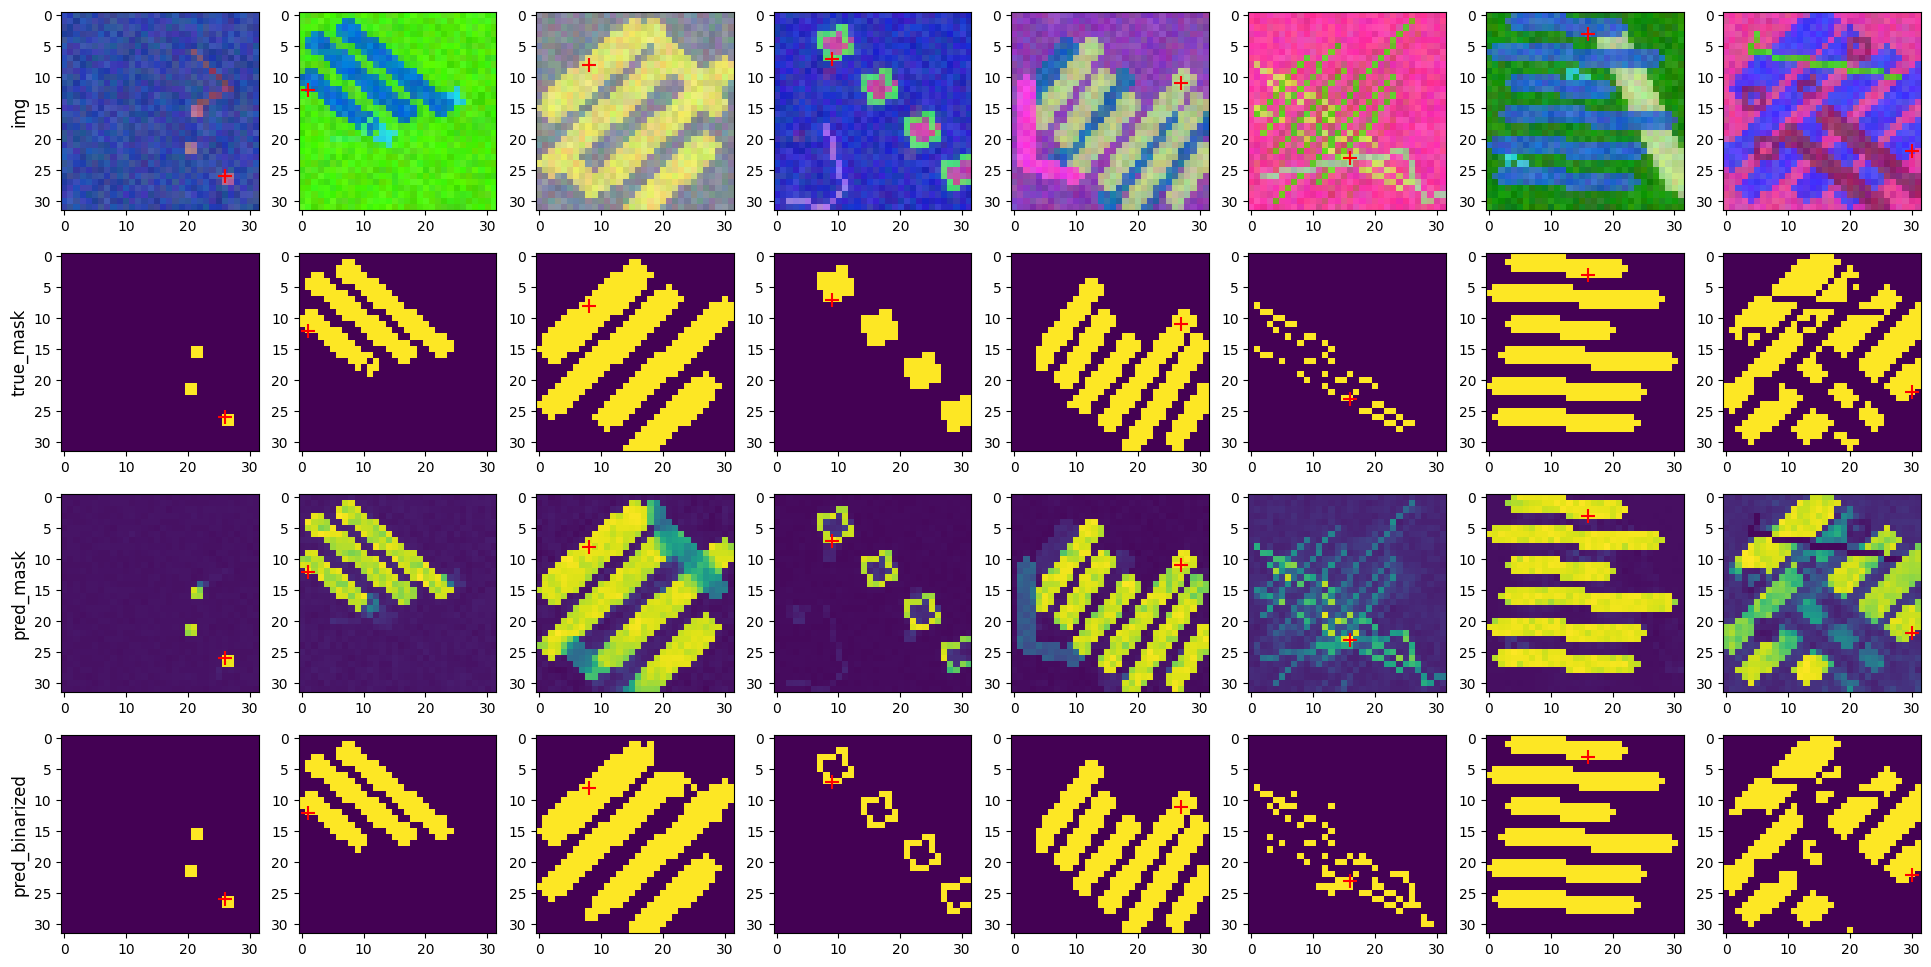

In [63]:
img, labels = next(test_iter)
s = len(img)
dot_labels = tf.squeeze(SqueezeImg()(labels), axis=-1)

pattern_labels = tf.reduce_sum(dot_labels[:,1:] + tf.random.uniform((s, dot_labels.shape[1]-1, 1), -0.5, 0.5), axis=1)
_, sample_points = tf.math.top_k(pattern_labels+tf.random.uniform(pattern_labels.shape, -0.1, 0.1), 1)
sample_points = sample_points[:,0]

dot_labels = tf.matmul(dot_labels, dot_labels, transpose_a=True)

preds = trainer.model(img, training=False)
#print(labels.shape, preds.shape)
print('total F1:', WeightedF12D()(dot_labels, preds).numpy())

#sample_points = tf.random.uniform((s,), 0, 32**2, dtype=tf.int32)
sample_labels = UnSqueezeImg()(tf.gather(dot_labels, sample_points[...,tf.newaxis], axis=1, batch_dims=1)[:,0,:,tf.newaxis])
sample_preds = UnSqueezeImg()(tf.gather(preds, sample_points[...,tf.newaxis], axis=1, batch_dims=1)[:,0,:,tf.newaxis])

print('weighted F1:', vcm.PixelSimilarityF1()(labels, preds).numpy())
print('sample F1:', WeightedF12D()(sample_labels, sample_preds).numpy())

bin_sample_preds = tf.where(sample_preds>0.5, 1, 0)

sample_points = decode1Dcoords(sample_points, 32)

#print(sample_labels.shape, sample_preds.shape, sample_points.shape)

fig, axs = plt.subplots(4, s, figsize=(s*3, 4*3))

for i in range(s):
    axs[0,i].imshow(img[i]) 
    axs[1,i].imshow(sample_labels[i], vmin=0, vmax=1)
    axs[2,i].imshow(sample_preds[i], vmin=0, vmax=1)
    axs[3,i].imshow(bin_sample_preds[i], vmin=0, vmax=1)

    for j in range(4):
        axs[j,i].scatter(*sample_points[i], marker='+', color='red', s=100)

    for i, title in enumerate(['img', 'true_mask', 'pred_mask', 'pred_binarized']):
        axs[i,0].set_ylabel(title, rotation=90, fontsize=12)